In [1]:
### import required libraries and pkgs ###
import glob
import os
import librosa
import numpy as np
#from sklearn.model_selection import KFold
#from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
#import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [6]:

def Myextract_features(filePath, sampleRate=44100):
    factor = 0.4
    
    signal,sr = librosa.load(filePath, sampleRate)
    signal = librosa.effects.time_stretch(signal,factor)
    centroid = librosa.feature.spectral_centroid(y=signal,sr=sr)
    mfcc = librosa.feature.mfcc(y=signal, sr=sr)
    #features = librosa.feature.melspectrogram(y=signal,sr=sr, n_mels=1)
    mel = librosa.feature.melspectrogram(y=signal, sr=sr)

    features = np.concatenate((mel,mfcc,centroid),axis=0)
    #features = np.concatenate((centroid,slope),axis=0)
    
    return features

In [7]:
import pandas as pd
import numpy as np
import librosa

filenames = pd.read_csv('/Users/pooyan/Documents/CMMS/normal.csv')
#convert filenames from dataframe to array
filenames = np.array(filenames['name'].values)
#read all noraml files
parent_dir = '/Users/pooyan/Desktop/data_cmms/skytraina_06252019/turbo/'
sub_dir = 'combine/'
file_ext='*.ogg'
#all_Normalfiles = glob.glob(os.path.join(parent_dir, sub_dir, file_ext))[0:2500]
all_Normalfiles = parent_dir +sub_dir+ filenames


all_noraml_features = [] #define an empty array
all_noraml_labels = []
for i in range(0,len(all_Normalfiles)):
    my_features = Myextract_features(all_Normalfiles[i])
    all_noraml_features.append(my_features)
    all_noraml_labels.append("normal")

#use reshape to conver outputs into arrays
dim_1 = len(all_Normalfiles)
dim_2 = my_features.shape[0] #number of features
dim_3 = my_features.shape[1]
all_noraml_features = np.asarray(all_noraml_features).reshape(dim_1, dim_2, dim_3)
all_noraml_labels = np.asarray(all_noraml_labels).reshape(dim_1)

#check the dimentions
print(all_noraml_features.shape)
print(all_noraml_labels.shape)

#read all anoamly files
filenames = pd.read_csv('/Users/pooyan/Documents/CMMS/anomaly.csv')
#convert filenames from dataframe to array
filenames = np.array(filenames['name'].values)

parent_dir = '/Users/pooyan/Desktop/data_cmms/skytraina_06252019/turbo/'
sub_dir = 'combine/'
file_ext='*.ogg'
#all_Anomalyfiles = glob.glob(os.path.join(parent_dir, sub_dir, file_ext))[0:1000]
all_Anomalyfiles = parent_dir +sub_dir+ filenames

all_anomaly_features = [] #define an empty array
all_anomaly_labels = []
for i in range(0,len(all_Anomalyfiles)):
    my_features = Myextract_features(all_Anomalyfiles[i])
    all_anomaly_features.append(my_features)
    all_anomaly_labels.append("anomaly")

#use reshape to conver outputs into arrays
dim_1 = len(all_Anomalyfiles)
dim_2 = my_features.shape[0] #number of features
dim_3 = my_features.shape[1]
all_anomaly_features = np.asarray(all_anomaly_features).reshape(dim_1, dim_2, dim_3)
all_anomaly_labels = np.asarray(all_anomaly_labels).reshape(dim_1)

#check the dimentions
print(all_anomaly_features.shape)
print(all_anomaly_labels.shape)

#Merge noraml and anomaly arrays
all_data = np.concatenate((all_noraml_features,all_anomaly_features),axis=0)
all_label = np.concatenate((all_noraml_labels,all_anomaly_labels),axis=0)

#check the dimentions
print(all_data.shape)

(8633, 149, 646)
(8633,)
(2308, 149, 646)
(2308,)
(10941, 149, 646)


In [10]:
#endocding labels
my_ec = LabelEncoder()
all_label = my_ec.fit_transform(all_label)

my_ec.transform(["normal"])
my_ec.inverse_transform(all_label)

#split data into train. validation, and test
X_train, X_test, y_train, y_test = train_test_split(all_data,all_label,test_size=0.2,shuffle=True)
X_train, X_validation, y_train, y_validation = train_test_split(X_train,y_train,test_size=0.2,shuffle=True)

#check the dimentions
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

#check the dimentions
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(7001, 149, 646)
(2189, 149, 646)
(1751, 149, 646)
(7001, 149, 646)
(2189, 149, 646)
(1751, 149, 646)


In [11]:
# two sided model
#from keras.layers.core import Input, Model
from keras.layers import *
from keras.models import *
from keras.utils import *
from keras.initializers import *
import tensorflow as tf


inputs = Input((149,646))

side1 = Bidirectional(LSTM(100, return_sequences=True))(inputs) #200 total units
side2 = Conv1D(200, kernel_size=3, activation = 'relu', padding = 'same')(inputs) #same activation 
                                                                   #same length

merged = Add()([side1, side2]) 
     #or Concatenate()([side1, side2]) if different number of units/channels/features

outputs = Conv1D(200, kernel_size=3)(merged)
outputs = GlobalMaxPooling1D()(outputs)
outputs = Dense(100)(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 149, 646)]   0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 149, 200)     597600      ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 149, 200)     387800      ['input_1[0][0]']                
                                                                                                  
 add (Add)                      (None, 149, 200)     0           ['bidirectional[0][0]',          
                                                                  'conv1d[0][0]']             

In [12]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy", "MeanSquaredError"])
history=model.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 20, batch_size = 128, verbose = 1)


Epoch 1/20
55/55 [==============================] - 26s 414ms/step - loss: 71.5989 - accuracy: 0.8990 - mean_squared_error: 0.4999 - val_loss: 8.9791 - val_accuracy: 0.9806 - val_mean_squared_error: 0.5000
Epoch 2/20
55/55 [==============================] - 22s 395ms/step - loss: 4.9826 - accuracy: 0.9880 - mean_squared_error: 0.5000 - val_loss: 6.6965 - val_accuracy: 0.9783 - val_mean_squared_error: 0.4999
Epoch 3/20
55/55 [==============================] - 22s 400ms/step - loss: 1.5332 - accuracy: 0.9929 - mean_squared_error: 0.5000 - val_loss: 6.4982 - val_accuracy: 0.9760 - val_mean_squared_error: 0.4999
Epoch 4/20
55/55 [==============================] - 23s 410ms/step - loss: 0.6780 - accuracy: 0.9957 - mean_squared_error: 0.4999 - val_loss: 6.5891 - val_accuracy: 0.9846 - val_mean_squared_error: 0.5000
Epoch 5/20
55/55 [==============================] - 22s 403ms/step - loss: 0.4071 - accuracy: 0.9961 - mean_squared_error: 0.4999 - val_loss: 5.7654 - val_accuracy: 0.9874 - val_m

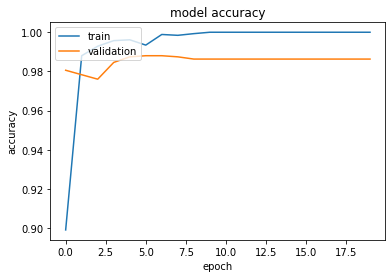

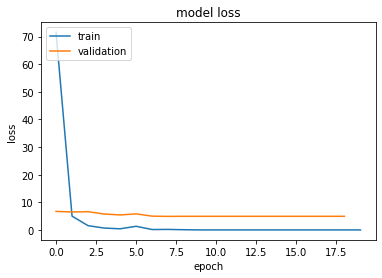

In [13]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'][1:43])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
#test
pred = model.predict(X_test)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]

#test

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.985838
Precision: 0.994166
Recall: 0.987826
F1 score: 0.990986
Cohens kappa: 0.957973
ROC AUC: 0.983137
[[ 454   10]
 [  21 1704]]


In [15]:
from sklearn.metrics import confusion_matrix

pred = model.predict(X_train)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
Cohens kappa: 1.000000
ROC AUC: 1.000000
[[1461    0]
 [   0 5540]]


<AxesSubplot:>

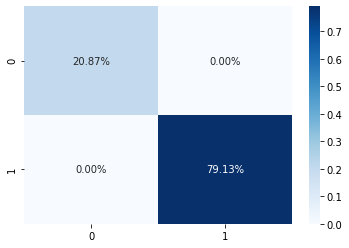

In [21]:
import numpy as np
import seaborn as sns

sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [4]:
#50epochs
def Myextract_features(filePath, sampleRate=44100):
    factor = 0.4
    
    signal,sr = librosa.load(filePath, sampleRate)
    signal = librosa.effects.time_stretch(signal,factor)
    centroid = librosa.feature.spectral_centroid(y=signal,sr=sr)
    mfcc = librosa.feature.mfcc(y=signal, sr=sr)
    #features = librosa.feature.melspectrogram(y=signal,sr=sr, n_mels=1)
    mel = librosa.feature.melspectrogram(y=signal, sr=sr)

    features = np.concatenate((mel,mfcc,centroid),axis=0)
    #features = np.concatenate((centroid,slope),axis=0)
    
    return features

In [5]:
import pandas as pd
import numpy as np
import librosa

filenames = pd.read_csv('/Users/pooyan/Documents/CMMS/normal.csv')
#convert filenames from dataframe to array
filenames = np.array(filenames['name'].values)
#read all noraml files
parent_dir = '/Users/pooyan/Desktop/data_cmms/skytraina_06252019/turbo/'
sub_dir = 'combine/'
file_ext='*.ogg'
#all_Normalfiles = glob.glob(os.path.join(parent_dir, sub_dir, file_ext))[0:2500]
all_Normalfiles = parent_dir +sub_dir+ filenames


all_noraml_features = [] #define an empty array
all_noraml_labels = []
for i in range(0,len(all_Normalfiles)):
    my_features = Myextract_features(all_Normalfiles[i])
    all_noraml_features.append(my_features)
    all_noraml_labels.append("normal")

#use reshape to conver outputs into arrays
dim_1 = len(all_Normalfiles)
dim_2 = my_features.shape[0] #number of features
dim_3 = my_features.shape[1]
all_noraml_features = np.asarray(all_noraml_features).reshape(dim_1, dim_2, dim_3)
all_noraml_labels = np.asarray(all_noraml_labels).reshape(dim_1)

#check the dimentions
print(all_noraml_features.shape)
print(all_noraml_labels.shape)

#read all anoamly files
filenames = pd.read_csv('/Users/pooyan/Documents/CMMS/anomaly.csv')
#convert filenames from dataframe to array
filenames = np.array(filenames['name'].values)

parent_dir = '/Users/pooyan/Desktop/data_cmms/skytraina_06252019/turbo/'
sub_dir = 'combine/'
file_ext='*.ogg'
#all_Anomalyfiles = glob.glob(os.path.join(parent_dir, sub_dir, file_ext))[0:1000]
all_Anomalyfiles = parent_dir +sub_dir+ filenames

all_anomaly_features = [] #define an empty array
all_anomaly_labels = []
for i in range(0,len(all_Anomalyfiles)):
    my_features = Myextract_features(all_Anomalyfiles[i])
    all_anomaly_features.append(my_features)
    all_anomaly_labels.append("anomaly")

#use reshape to conver outputs into arrays
dim_1 = len(all_Anomalyfiles)
dim_2 = my_features.shape[0] #number of features
dim_3 = my_features.shape[1]
all_anomaly_features = np.asarray(all_anomaly_features).reshape(dim_1, dim_2, dim_3)
all_anomaly_labels = np.asarray(all_anomaly_labels).reshape(dim_1)

#check the dimentions
print(all_anomaly_features.shape)
print(all_anomaly_labels.shape)

#Merge noraml and anomaly arrays
all_data = np.concatenate((all_noraml_features,all_anomaly_features),axis=0)
all_label = np.concatenate((all_noraml_labels,all_anomaly_labels),axis=0)

#check the dimentions
print(all_data.shape)

(8633, 149, 646)
(8633,)
(2308, 149, 646)
(2308,)
(10941, 149, 646)


In [6]:
#endocding labels
my_ec = LabelEncoder()
all_label = my_ec.fit_transform(all_label)

my_ec.transform(["normal"])
my_ec.inverse_transform(all_label)

#split data into train. validation, and test
X_train, X_test, y_train, y_test = train_test_split(all_data,all_label,test_size=0.2,shuffle=True)
X_train, X_validation, y_train, y_validation = train_test_split(X_train,y_train,test_size=0.2,shuffle=True)

#check the dimentions
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

#check the dimentions
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(7001, 149, 646)
(2189, 149, 646)
(1751, 149, 646)
(7001, 149, 646)
(2189, 149, 646)
(1751, 149, 646)


In [7]:
# two sided model
#from keras.layers.core import Input, Model
from keras.layers import *
from keras.models import *
from keras.utils import *
from keras.initializers import *
import tensorflow as tf


inputs = Input((149,646))

side1 = Bidirectional(LSTM(100, return_sequences=True))(inputs) #200 total units
side2 = Conv1D(200, kernel_size=3, activation = 'relu', padding = 'same')(inputs) #same activation 
                                                                   #same length

merged = Add()([side1, side2]) 
     #or Concatenate()([side1, side2]) if different number of units/channels/features

outputs = Conv1D(200, kernel_size=3)(merged)
outputs = GlobalMaxPooling1D()(outputs)
outputs = Dense(100)(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 149, 646)]   0           []                               
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 149, 200)    597600      ['input_2[0][0]']                
 )                                                                                                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 149, 200)     387800      ['input_2[0][0]']                
                                                                                                  
 add_1 (Add)                    (None, 149, 200)     0           ['bidirectional_1[0][0]',  

In [8]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy", "MeanSquaredError"])
history=model.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 50, batch_size = 128, verbose = 1)


Epoch 1/50
55/55 [==============================] - 27s 441ms/step - loss: 124.2352 - accuracy: 0.8924 - mean_squared_error: 0.4999 - val_loss: 18.3200 - val_accuracy: 0.9726 - val_mean_squared_error: 0.5000
Epoch 2/50
55/55 [==============================] - 22s 408ms/step - loss: 5.4266 - accuracy: 0.9876 - mean_squared_error: 0.4999 - val_loss: 10.6781 - val_accuracy: 0.9886 - val_mean_squared_error: 0.5000
Epoch 3/50
55/55 [==============================] - 22s 408ms/step - loss: 2.0649 - accuracy: 0.9933 - mean_squared_error: 0.5000 - val_loss: 8.9331 - val_accuracy: 0.9903 - val_mean_squared_error: 0.5000
Epoch 4/50
55/55 [==============================] - 23s 415ms/step - loss: 0.9882 - accuracy: 0.9954 - mean_squared_error: 0.5000 - val_loss: 10.0856 - val_accuracy: 0.9806 - val_mean_squared_error: 0.5000
Epoch 5/50
55/55 [==============================] - 22s 407ms/step - loss: 0.5730 - accuracy: 0.9961 - mean_squared_error: 0.4999 - val_loss: 8.7307 - val_accuracy: 0.9897 - v

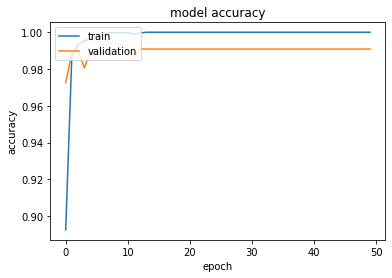

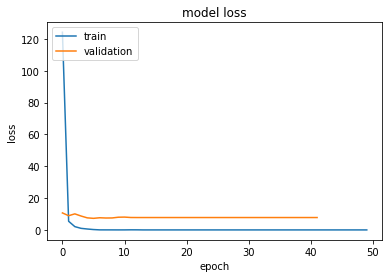

In [9]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'][1:43])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [10]:
#test
pred = model.predict(X_test)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]

#test

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

Accuracy: 0.992234
Precision: 0.992974
Recall: 0.997061
F1 score: 0.995013
Cohens kappa: 0.977470
ROC AUC: 0.986235
[[ 476   12]
 [   5 1696]]


In [11]:
#train
from sklearn.metrics import confusion_matrix

pred = model.predict(X_train)
y_pred = [0 if y[0]>y[1] else 1 for y in pred]   #thereshold=50 y[0]>0.50


from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_train, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_train, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_train, y_pred)
print(matrix)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
Cohens kappa: 1.000000
ROC AUC: 1.000000
[[1484    0]
 [   0 5517]]


<AxesSubplot:>

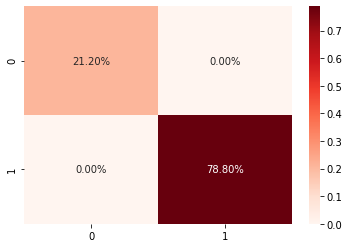

In [19]:
import numpy as np
import seaborn as sns

sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%', cmap='Reds')

<AxesSubplot:>

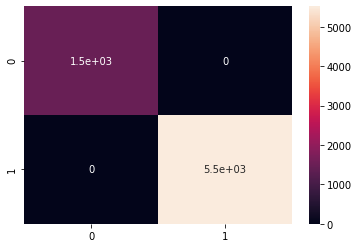

In [13]:
import seaborn as sns
sns.heatmap(matrix, annot=True)

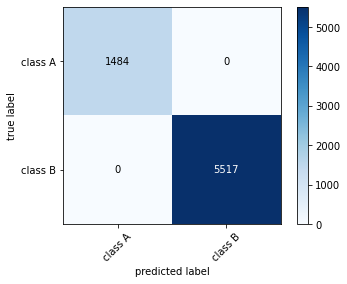

In [18]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = np.array([[1484, 0],
               [0, 5517]])

# Classes
classes = ['class A', 'class B']

figure, ax = plot_confusion_matrix(conf_mat = cm,
                                   class_names = classes,
                                   show_absolute = True,
                                   show_normed = False,
                                   colorbar = True)

plt.show()

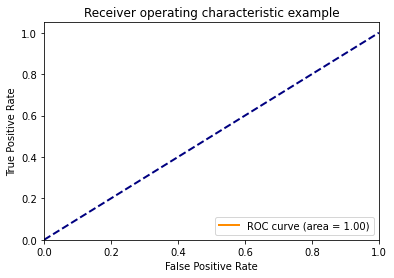

In [22]:
plt.figure()
lw = 2
plt.plot(
    1.0,
    1.0,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % 1.0,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

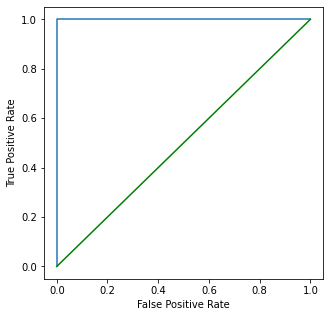

In [25]:
#auc
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

def plot_sklearn_roc_curve(y_real, y_pred):
    fpr, tpr, _ = roc_curve(y_real, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')
# Plots the ROC curve using the sklearn methods - Good plot
#plot_sklearn_roc_curve(y_test, y_pred[:, 1])
# Plots the ROC curve using the sklearn methods - Bad plot
plot_sklearn_roc_curve(y_train, y_pred)

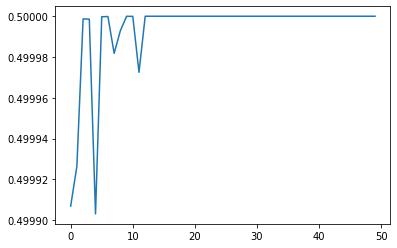

In [26]:
import matplotlib.pyplot 

plt.plot(history.history['mean_squared_error'])
plt.show()

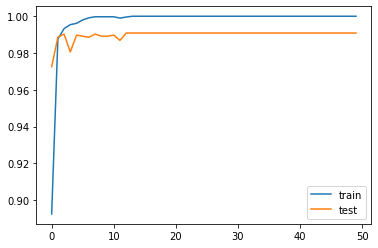

In [28]:
# learning curves of model accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [29]:
#validation 
from sklearn.metrics import confusion_matrix

pred = model.predict(X_validation)
y_pred = [0 if y[0]>y[1] else 1 for y in pred] 

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_validation, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_validation, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_validation, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_validation, y_pred)
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_validation, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_validation, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_validation, y_pred)
print(matrix)

Accuracy: 0.990862
Precision: 0.993649
Recall: 0.995053
F1 score: 0.994350
Cohens kappa: 0.970470
ROC AUC: 0.984134
[[ 327    9]
 [   7 1408]]


In [31]:
# two sided model
#from keras.layers.core import Input, Model
from keras.layers import *
from keras.models import *
from keras.utils import *
from keras.initializers import *
import tensorflow as tf


inputs = Input((149,646))

side1 = Bidirectional(LSTM(100, return_sequences=True))(inputs) #200 total units
side2 = Conv1D(200, kernel_size=3, activation = 'relu', padding = 'same')(inputs) #same activation 
                                                                   #same length

merged = Add()([side1, side2]) 
     #or Concatenate()([side1, side2]) if different number of units/channels/features

outputs = Conv1D(200, kernel_size=3)(merged)
outputs = GlobalMaxPooling1D()(outputs)
outputs = Dense(100)(outputs)
outputs = Dropout(0.2)(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 149, 646)]   0           []                               
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 149, 200)    597600      ['input_4[0][0]']                
 )                                                                                                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 149, 200)     387800      ['input_4[0][0]']                
                                                                                                  
 add_3 (Add)                    (None, 149, 200)     0           ['bidirectional_3[0][0]',  

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy", "MeanSquaredError"])
history=model.fit(X_train, y_train, validation_data=(X_validation, y_validation),epochs = 50, batch_size = 128, verbose = 1)
